# Test for causation: Convergent Cross Mapping

This method looks for the signature of time-series $x_1$ in time-series $x_2$ by seeing whether there is a correspondence between the library of points in the attractor manifold built from $x_2$, $M_2$, and points in the $x_1$ manifold, $M_1$, where these two manifolds are constructed from lagged coordinates of the time-series variables. For more details on that, please refer to the notebook "Nonlinear prediction of chaotic dynamical systems"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import dataset
import statsmodels.api as sm

Consider as an example the dataset included in statsmodel, German inflation rate vs. interest 1972-1998 (measured each quartile). 
A proxy for inflation is a measure of GDP deflator (\url{https://en.wikipedia.org/wiki/GDP_deflator}). 
Here (https://www.statsmodels.org/dev/datasets/generated/interest_inflation.html) it is reported the delta of the log GDP deflator (Dp) vs. the long term interest rate (r). 

In [2]:
data = sm.datasets.interest_inflation.load()

In [4]:
# We are interested in Dp and rate (see documentation)
Dp = data['data']['Dp']
rate = data['data']['R']

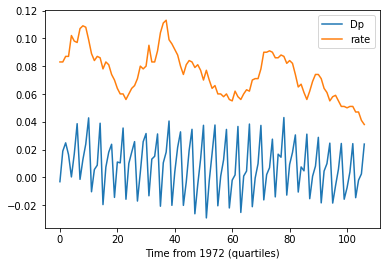

In [8]:
plt.plot(Dp,label='Dp')
plt.plot(rate,label='rate')
plt.legend()
plt.xlabel('Time from 1972 (quartiles)')
plt.show()

#### Is there causation? I.e., does the interest rate affect the GDP? Or is the opposite true?

In 2012 Sugihara et al. (https://www.science.org/doi/10.1126/science.1227079) proposed a method for testing causation in dynamical systems called Convergent Cross-Mapping (CCM).

Practically, the idea is to test whether nearby points on the $M_2$ manifold can be used to identify nearby points on $M_1$. If so, then one can use $x_2$ to estimate $x_1$ and vice versa!

In detail, CCM proceeds as follows:

**(1)** Given an embedding dimension $n$, compute lag-vectors $x_1^p(t) = [ x_1(t), x_1(t-1), \dots, x_1(t-n)]$ for $t = n, n+1, \dots, T$
**(2)** Find the $n+1$ nearest neighbors of each lag-vector $x_1^p(t^*)$, which will give a set of Euclidean distances 
    \begin{equation}
    \label{CCM_dis}\tag{1}
        \{ d_1, \dots, d_{n+1}\}_{t^*}
    \end{equation} 
    and associated times 
    \begin{equation}\label{CCM_tims}\tag{2}
        \{\hat t_1, \dots, \hat t_{n+1}\}_{t^*}
    \end{equation}
**(3)** Find the corresponding weights of the neighbors using (\ref{CCM_dis}): 
    \begin{equation}\label{CCM_weights}\tag{3}
    w_i = \frac{e^{-d_i}}{\sum_i^{n+1} e^{-d_i}}
    \end{equation}
    
**(4)** Predict $x_2(t^*)$ based on using the weights (\ref{CCM_weights}) and times (\ref{CCM_tims}), which were computed from $x_1$, and accordingly denote this by $\hat x_2(t^*)_{| x_1}$:
    \begin{equation}\tag{4}
    \hat x_2(t^*)_{| x_1} = \sum_i^{n+1} w_i x_2(\hat t_i)
    \end{equation}
**(5)** Compute the squared correlation between real $x_2$ and reconstructed time series $\hat x_2{}_{|x_1}$ as 
    \begin{equation}\label{CCM_corr}\tag{5}
    C_{2|1} = \rho (x_2, \hat x_2{}_{| x_1})^2
    \end{equation}
Any pair of times series then has two CCM correlations, $C_{1|2}$ and $C_{2|1}$, which allow to determine CCM causality.  Afterwards, several scenarios are possible, as explained below. If $x_2$ can be estimated using $x_1$, but $x_1$ cannot be estimated using $x_2$, then $x_1$ is said to ``CCM cause'' $x_2$. In particular, Sugihara and colleagues define a difference of CCM correlations to determine the CCM causality between $x_1$ and $x_2$:
\begin{equation}
    \Delta_C = C_{1|2} - C_{2|1}.
\end{equation}
By studying the sign of $\Delta_C$, and the magnitudes of $C_{1|2}$ and $C_{2|1}$ it is possible to fix thresholds to determine the flow of information. It is possible that the causality flow is balanced ($\Delta_C \approx 0$ and $C_{1|2} \approx C_{2|1} \approx 1$), or unbalanced ($|\Delta_C| > 0$) or absent ($C_{1|2} \approx C_{2|1} \approx 0$).

The CCM algorithm depends on the embedding dimension $n$. The optimal embedding dimension and time lag are found by analysing the nonlinear prediction of the single time series, similarly to what we explained in the previous notebook.

In [10]:
### these are the scripts explained in the previous notebook ###

from sklearn.neighbors import NearestNeighbors
from scipy import stats as stats

# split dataset into train/test
def train_test_split(X, fraction_train=.75):
    split = int(len(X)*fraction_train)
    return X[:split], X[split:]

# exponential weights: w_i = exp(-d_i) / sum_i exp(-d_i)
def weights(distances):
    num = np.exp(-distances) # numerator: e^{-d_i}
    den = np.sum(num,axis=1,keepdims=True) # denominator: sum_i e^{-d_i}
    return num/den

# embed vectors into n-dimensional past values (the last element is the one to be predicted)
def embed_vectors(X, n_embed):
    size = len(X)
    leng = size-n_embed
    out_vects = np.zeros((leng,n_embed + 1))
    for i in range(leng):
        out_vects[i,:] = X[i:i+n_embed+1]
    return out_vects

# implement the Sugihara nonlinear prediction
def nonlinear_prediction(X_train, X_test, n_embed):

    # initialize nearest neighbors from sklearn
    knn = NearestNeighbors(n_neighbors=n_embed+1)
    
    # Nearest neigbors is fit on the train data (only on the past vectors - i.e. till [:-1])
    knn.fit(X_train[:,:-1])

    # find the nearest neighbors for each test vector input
    dist,ind = knn.kneighbors(X_test[:,:-1])

    # compute exponential weights given distances
    W = weights(dist)

    # predict test using train (weighted average)
    x_pred = np.sum(X_train[ind][:,-1] * W, axis=1)

    return x_pred

In [23]:
### this is the novel part ###

# this algorithm is very similar to the previous "nonlinear_prediction"
# the only tricky part is that weights for X1 are used to predict X2, and vice versa!

def ccm_predict(X1_train, X2_train, X1_test, X2_test,n_embed):

    # initialize nearest neighbors from sklearn
    knn1 = NearestNeighbors(n_neighbors=n_embed+1)
    knn2 = NearestNeighbors(n_neighbors=n_embed+1)
    knn1.fit(X1_train[:,:-1])
    knn2.fit(X2_train[:,:-1])

    # find the nearest neighbors for each test vector input
    dist1,ind1 = knn1.kneighbors(X1_test[:,:-1])
    dist2,ind2 = knn2.kneighbors(X2_test[:,:-1])

    # compute exponential weights given distances
    W1 = weights(dist1)
    W2 = weights(dist2)

    # predict x1 using ind2, W2, and opposite predicte x2 using ind1, W1
    x1_p = np.sum(X1_train[ind2][:,-1] * W2, axis=1)
    x2_p = np.sum(X2_train[ind1][:,-1] * W1, axis=1)

    return x1_p, x2_p

Now it's time to apply this method to the data.

First, let's find the best embedding dimension.

In [77]:
# find best embedding by using nonlinear prediction of each time series
nonlinear_reconstr_cor = []
nonlinear_reconstr_ssr = []
for n_embed in np.arange(1,20):

    # embed points in n_embed-dimensional space
    X1 = embed_vectors(Dp,n_embed)
    X2 = embed_vectors(rate,n_embed)

    # split train/test  
    X1_train, X1_test = train_test_split(X1, fraction_train=0.7)
    X2_train, X2_test = train_test_split(X2, fraction_train=0.7)
    # nonlinear prediction on individual time series
    x1_p = nonlinear_prediction(X1_train, X1_test, n_embed)
    x2_p = nonlinear_prediction(X2_train, X2_test, n_embed)

    # simply check correlation
    nonlinear_reconstr_cor.append([np.corrcoef(X1_test[:,-1], x1_p)[0,1],
                                 np.corrcoef(X2_test[:,-1], x2_p)[0,1]])
    
    # measure sum squared residuals
    nonlinear_reconstr_ssr.append([np.sum((X1_test[:,-1] - x1_p)**2), 
                                   np.sum((X2_test[:,-1] - x2_p)**2)])

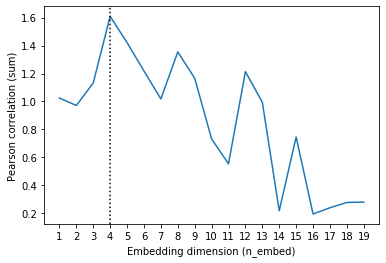

In [78]:
plt.plot(np.arange(1,20),np.sum(nonlinear_reconstr_cor,1))
plt.xticks(np.arange(1,20))
plt.xlabel('Embedding dimension (n_embed)')
plt.ylabel('Pearson correlation (sum)')
plt.axvline(x=4,color='k',ls='dotted')
plt.show()

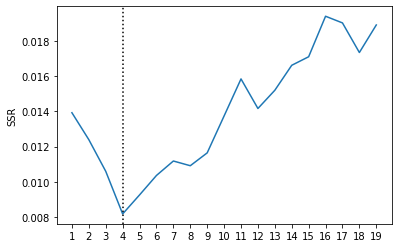

In [79]:
plt.plot(np.arange(1,20),np.sum(nonlinear_reconstr_ssr,1))
plt.xticks(np.arange(1,20))
plt.axvline(x=4,color='k',ls='dotted')
plt.ylabel('SSR')
plt.show()

Now, let's predict "each other" using CCM

In [49]:
n_embed = 4 # best one according to previous plot

X1 = embed_vectors(Dp,n_embed)
X2 = embed_vectors(rate,n_embed)

In [65]:
# split train/test
X1_train, X1_test = train_test_split(X1, fraction_train=0.7)
X2_train, X2_test = train_test_split(X2, fraction_train=0.7)

# prediction
x1_pred, x2_pred = ccm_predict(X1_train,X2_train,X1_test, X2_test,n_embed)

Now check whether the prediction of X1 (based on X2) is good:

In [68]:
stats.pearsonr(x1_pred,X1_test[:,-1])

(0.3482430948233711, 0.05487831860154601)

In [69]:
stats.pearsonr(x2_pred,X2_test[:,-1])

(0.28489860459616817, 0.12031416240759091)

Now, we see that X1 (i.e. DP, which is a proxy for inflation) can be predicted better than X2 (i.e. interest rate).

We conclude that rate CCM-causes inflation.

## Comparison with Granger Causality

In [70]:
from statsmodels.tsa.stattools import grangercausalitytests

Let's begin to test whether interest rate Granger-causes DP (i.e. inflation)

In [74]:
gra_res = grangercausalitytests(np.array([Dp,rate]).T, maxlag=5,verbose=False)
gra_res[1]

({'ssr_ftest': (6.8945947764847855, 0.009962976033159838, 103.0, 1),
  'ssr_chi2test': (7.095408216576575, 0.007728168786045521, 1),
  'lrtest': (6.868025019467723, 0.008775157719255171, 1),
  'params_ftest': (6.894594776484797, 0.00996297603315977, 103.0, 1.0)},
  array([[0., 1., 0.]])])

Yes, the test is significant. We can reject the null hypothesis of interest rate NOT causing DP

Now test the opposite: does infaltion cause interest rate?

In [75]:
gra_res = grangercausalitytests(np.array([rate,Dp]).T, maxlag=5,verbose=False)
gra_res[1]

({'ssr_ftest': (0.031230236128532308, 0.8600747368583583, 103.0, 1),
  'ssr_chi2test': (0.03213985465654781, 0.8577210554160729, 1),
  'lrtest': (0.03213498313994023, 0.8577317235928832, 1),
  'params_ftest': (0.03123023612851477, 0.8600747368584091, 103.0, 1.0)},
  array([[0., 1., 0.]])])

The test is not significant. We cannot reject the null hypothesis of DP NOT causing interest rate